<h1 style="text-align: center">
Deep Learning HW4 </br>
Ferdousi Generator
</h1>

### Full Name: Borna khodabandeh
### Student ID: 400109898

# Ferdousi Gen

This project is for a text generator inspired by Ferdousi, which likely involves training a language model(`GPT2`) on the works of Ferdousi, the renowned Persian poet, to generate new text in a similar style or theme.

## Environment Setup


In [135]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from os import path

from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"using {device} device")

using cuda device


## Dataset Preparation

### Ferdousi Dataset Class
We define a custom dataset class `FerdousiDataset` to load the Shahnameh of Ferdousi dataset. It reads the dataset, removes metadata, and organizes the data into stanzas.

In [136]:
class FerdousiDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.data = self._load_data()
        
    def _load_data(self):
        with open(self.root_dir, 'r') as file:
            lines = file.readlines()
        
        # Remove metadata, split into beyts
        lines = [line.strip('\n') for line in lines]
        lines = lines[2:]
        lines = lines[0:2 * (len(lines) // 2)]
        
        # Per stanza
        data = {
            'stanza_1': lines[0::2],
            'stanza_2': lines[1::2],
            'len': len(lines) // 2,
        }

        # Per beyt
#         beyt = [stanza1 + ', ' + stanza2 for stanza1, stanza2 in zip(lines[0::2], lines[1::2])]
#         beyt = beyt[0:2 * (len(beyt) // 2)]
        
#         data = {
#             'stanza_1': beyt[0::2],
#             'stanza_2': beyt[1::2],
#             'len': len(beyt) // 2,
#         }
        
        return data

    def __getitem__(self, idx):
        if idx < len(self):
            return self.data['stanza_1'][idx], self.data['stanza_2'][idx]
        return None
    
    def __len__(self):
        return self.data['len']


### Dataset Splitting
We split the dataset into training and testing sets.

In [137]:
base_path = '/kaggle/input/ferdousi-text/ferdousi.txt'
train_test_ratio = 0.9

dataset = FerdousiDataset(base_path)

num_samples = len(dataset)
train_size = int(train_test_ratio * num_samples)
test_size = num_samples - train_size
dataset_train, dataset_test = random_split(dataset, [train_size, test_size])

# Check the dataset sizes
print(f"Number of training examples: {len(dataset_train)}")
print(f"Number of test examples: {len(dataset_test)}")

print('Samples from dataset:')

for (stanza_1, stanza_2) in dataset:
    print(f'{stanza_1 = }')
    print(f'{stanza_2 = }')
    break

Number of training examples: 44647
Number of test examples: 4961
Samples from dataset:
stanza_1 = 'به نام خداوند جان و خرد'
stanza_2 = 'کزین برتر اندیشه برنگذرد'


## Tokenization and Model Loading

We load the GPT-2 model for the Persian language (`HooshvareLab/gpt2-fa`) and initialize a tokenizer with special tokens.

In [138]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoConfig

model_name = "HooshvareLab/gpt2-fa"

special_tokens = {
#     "bos_token": '<cls>',
    "bos_token": '<s>',
#     "eos_token": '<sep>',
    "eos_token": '</s>',
    "unk_token": '<unk>',
    "pad_token": '<pad>',
}

opt = {
    **special_tokens,
    "padding_side": "right", # Persian 
    "model_max_length": 16, # chosen by viewing the dataset
    "model_name": model_name,
}

tokenizer = AutoTokenizer.from_pretrained(model_name, **opt)

tokenizer.add_special_tokens(special_tokens)

config = AutoConfig.from_pretrained(model_name, **tokenizer.special_tokens_map)

print(f'Vocab size: {len(tokenizer)}')
tokenizer.special_tokens_map

Vocab size: 42001


{'bos_token': '<s>',
 'eos_token': '</s>',
 'unk_token': '<unk>',
 'pad_token': '<pad>'}

### TokenizedFerdousiDataset Class

We create a tokenized version of the dataset using the tokenizer. The `TokenizedFerdousiDataset` class tokenizes each stanza pair, preparing the data for model training.

In [139]:
from tqdm import tqdm

class TokenizedFerdousiDataset(Dataset):
    def __init__(self, ferdousiDataset, tokenizer):
        self.tokenizer = tokenizer
        self.ferdousiDataset = ferdousiDataset
        
        self.encodings = {
            'input_ids': [],
            'labels': [],
            'attention_mask': [],
        }
        
        for (stanza_1, stanza_2) in tqdm(ferdousiDataset, desc='Tokenizing'):
            input_enc = tokenizer(
                tokenizer.bos_token + stanza_1 + tokenizer.eos_token,
#                 tokenizer.bos_token + stanza_1 + tokenizer.eos_token + tokenizer.bos_token + stanza_1 + tokenizer.eos_token,
                truncation=True,
                padding="max_length"
            )

            target_enc = tokenizer(
                tokenizer.bos_token + stanza_2 + tokenizer.eos_token,
#                 tokenizer.bos_token + stanza_1 + tokenizer.eos_token + tokenizer.bos_token + stanza_1 + tokenizer.eos_token,
                truncation=True,
                padding="max_length"
            )
            
            self.encodings['input_ids'].append(torch.tensor(input_enc['input_ids']))
            self.encodings['labels'].append(torch.tensor(target_enc['input_ids']))
            self.encodings['attention_mask'].append(torch.tensor(input_enc['attention_mask']))

    def __getitem__(self, idx):
        return {
            'input_ids': self.encodings['input_ids'][idx],
            'labels': self.encodings['labels'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
        }

    def __len__(self):
        return len(self.ferdousiDataset)


### Creating dataloaders

here we create suitable dataloaders for the training and testing phase of our program.

we also sample some of the values to visualize the actual dataset.

In [140]:
tokenized_dataset_train = TokenizedFerdousiDataset(dataset_train, tokenizer)
tokenized_dataset_test = TokenizedFerdousiDataset(dataset_test, tokenizer)

batch_size = 128

train_dataloader = DataLoader(
    tokenized_dataset_train,
    batch_size=batch_size,
    shuffle=True,
    num_workers=os.cpu_count(),
    pin_memory=False
)
test_dataloader = DataLoader(
    tokenized_dataset_test,
    batch_size=batch_size,
    shuffle=True,
    num_workers=os.cpu_count(),
    pin_memory=False
)

if os.cpu_count() > 1:
    os.environ["TOKENIZERS_PARALLELISM"] = "true"

print('Samples from dataloader:')
for encoding in train_dataloader:
    input_ids = encoding['input_ids']
    target_ids = encoding['labels']
    print(f'{input_ids[0].shape = }')
    input_stanza_original = tokenizer.decode(input_ids[0])
    print(f'{input_stanza_original = }')
    input_stanza_clean = tokenizer.decode(input_ids[0], skip_special_tokens=True)
    target_stanza_clean = tokenizer.decode(target_ids[0], skip_special_tokens=True)
    print(f'{input_stanza_clean = }')
    print(f'{target_stanza_clean = }')
    poem = input_stanza_clean + ' , ' + target_stanza_clean
    print(f'{poem = }')
    break

Tokenizing: 100%|██████████| 4961/4961 [00:01<00:00, 3236.42it/s]


Samples from dataloader:
input_ids[0].shape = torch.Size([16])
input_stanza_original = '<s>بزرگان بارن دوده نفرین کنند</s><pad><pad><pad><pad><pad><pad><pad>'
input_stanza_clean = 'بزرگان بارن دوده نفرین کنند'
target_stanza_clean = 'سرازکشتن شاه پرکین کنند'
poem = 'بزرگان بارن دوده نفرین کنند , سرازکشتن شاه پرکین کنند'


## Loading the model

here we load the actual `GPT2LMHeadModel` for text generation, fitting it to our now modified tokenizer.

In [141]:
model = AutoModelForCausalLM.from_config(config)

model.resize_token_embeddings(len(tokenizer))
model = model.to(device)

parallel = torch.cuda.device_count() > 1

if parallel:
    model = nn.DataParallel(model)

optimizer = optim.Adam(model.parameters(), lr=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(42001, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=42001, bias=False)
)

### Sampling untrained model output

In [142]:
model.train()

for encoding in train_dataloader:
    encoding = {k:v.to(device) for k, v in encoding.items()}
    encoding.pop('labels')
    encoding['attention_mask'] = torch.ones_like(encoding['attention_mask']).to(device)
    gen = model.module if parallel else model
    outputs = gen.generate(
        **encoding,
        top_k=50,
        max_length=25,
        num_beams=5,
        no_repeat_ngram_size=2,
        num_return_sequences=1,
        pad_token_id=tokenizer.eos_token_id
    )
    in_stanza = tokenizer.decode(encoding['input_ids'][0], skip_special_tokens=True)
    out_stanza = tokenizer.decode(outputs[0])
    print('Input sequence: ')
    print(in_stanza)
    print('Output sequence: ')
    print(out_stanza)
    break

Input sequence: 
چنین گفت هومان به پیران شیر
Output sequence: 
<s>چنین گفت هومان به پیران شیر</s><pad><pad><pad><pad><pad><pad><pad> محققین سوب سوبیمه یلدادرگذشتهدرگذشته حاشیه حاشیه


### Simple function to calculate BLEU score

In [143]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def compute_bleu(output, reference):
    output_tokens = tokenizer.decode(output, skip_special_tokens=True)
    reference_tokens = tokenizer.decode(reference, skip_special_tokens=True)
    reference_words = nltk.word_tokenize(reference_tokens)
    output_words = nltk.word_tokenize(output_tokens)

    # Compute BLEU score
    smoothie = SmoothingFunction().method4
    bleu_score = sentence_bleu([reference_words], output_words, smoothing_function=smoothie)
    return bleu_score

hypothesis = tokenizer.encode('This is cat who love')
reference = tokenizer.encode('This is a cat who i love')
print(hypothesis)
BLEUscore = compute_bleu(hypothesis, reference)
print(BLEUscore)

[14943, 2433, 7557, 2578, 1276, 30436, 40981]
0.23852777905717912


## Model Training

The model is trained, and the training loss is plotted over epochs.
and each epoch we sample a random stanza and see the models prediction to visualize the training process's effect on the model generation.

In [144]:
num_epochs = 16
loss_dict = {'train_losses': [], 'val_losses': [], 'gen_bleu': [], 'perplexity': []}

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0

    for encoding in tqdm(train_dataloader, desc=f"Training loop {epoch+1}/{num_epochs}"):
        encoding = {k:v.to(device) for k, v in encoding.items()}
        encoding['attention_mask'] = torch.ones_like(encoding['attention_mask']).to(device)
        outputs = model(**encoding, token_type_ids=None)
        loss = outputs.loss
        total_train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_dataloader)
    loss_dict['train_losses'].append(avg_train_loss)
    
    model.eval()
    total_val_loss = 0

    with torch.no_grad():
        for val_encoding in tqdm(test_dataloader, desc=f"Validation loop {epoch+1}/{num_epochs}"):
            val_encoding = {k: v.to(device) for k, v in val_encoding.items()}
            val_outputs = model(**val_encoding, token_type_ids=None)
            val_loss = val_outputs.loss
            total_val_loss += val_loss.item()

        # Generate one sample
        print('generating sample: ')
        for gen_encoding in train_dataloader:
            gen_encoding = {k:v.to(device) for k, v in gen_encoding.items()}
            labels = gen_encoding['labels']
            gen_encoding.pop('labels')
            encoding['attention_mask'] = torch.ones_like(gen_encoding['attention_mask']).to(device)
            gen = model.module if parallel else model
            outputs = gen.generate(
                **gen_encoding,
                top_k=50,
                max_length=25,
                num_beams=5,
                no_repeat_ngram_size=2,
                num_return_sequences=1,
                pad_token_id=tokenizer.eos_token_id, # Open end generation
            )
            in_stanza = tokenizer.decode(encoding['input_ids'][0], skip_special_tokens=True)
            out_stanza = tokenizer.decode(outputs[0], skip_special_tokens=True)
            out_stanza = out_stanza.replace(in_stanza, in_stanza + ' ,')
            bleu = compute_bleu(outputs[0], labels[0])
            loss_dict['gen_bleu'].append(bleu)
            loss = gen(gen_encoding['input_ids'], labels=labels).loss
            perplexity = (torch.exp(loss).item())
            loss_dict['perplexity'].append(perplexity)
            print('Input sequence: ')
            print(in_stanza)
            print('Output sequence: ')
            print(out_stanza)
            print(f'{bleu = }, {perplexity = }')
            break

    avg_val_loss = total_val_loss / len(test_dataloader)
    loss_dict['val_losses'].append(avg_val_loss)

Validation loop 1/16: 100%|██████████| 39/39 [00:03<00:00, 10.28it/s]

generating sample: 


Input sequence: 
به گفتار بیکار با خسرویم
Output sequence: 
زریر سپهبد برادرش بود وندستند
bleu = 0.19879212680993805, perplexity = 28.0590763092041


Validation loop 2/16: 100%|██████████| 39/39 [00:03<00:00, 10.28it/s]

generating sample: 


Input sequence: 
همی تاخت کز روز بد بگذرد
Output sequence: 
چو بگذشت مانند کشتی به رود و باک کلاهدیو
bleu = 0, perplexity = 25.619173049926758


Validation loop 3/16: 100%|██████████| 39/39 [00:03<00:00, 10.49it/s]

generating sample: 


Input sequence: 
سخن چون به گوش سپهبد رسید
Output sequence: 
چو از دور گیو دلاور بدیدند بود کلاهند
bleu = 0.19817632389021378, perplexity = 26.37113380432129


Validation loop 4/16: 100%|██████████| 39/39 [00:03<00:00, 10.39it/s]

generating sample: 


Input sequence: 
از ایوان بشد نزد آن جشنگاه
Output sequence: 
فرستاده تازی برافگند و رفتند شدند آمدند ناز
bleu = 0.19817632389021378, perplexity = 24.505050659179688


Validation loop 5/16: 100%|██████████| 39/39 [00:03<00:00, 10.52it/s]

generating sample: 


Input sequence: 
پشوتن بدو گفت اینست راه
Output sequence: 
تو ما را بگفتار خامش کنیسار کلاهید همی
bleu = 0.19817632389021378, perplexity = 23.709903717041016


Validation loop 6/16: 100%|██████████| 39/39 [00:03<00:00, 10.49it/s]

generating sample: 


Input sequence: 
بپیش اندرون خون همی ریختند
Output sequence: 
بگرود به یزدان وتن پرگناه آمدندارافتندودار
bleu = 0, perplexity = 23.07831382751465


Validation loop 7/16: 100%|██████████| 39/39 [00:03<00:00, 10.45it/s]

generating sample: 


Input sequence: 
درختی زدند از بر گاه شاه
Output sequence: 
نهاد از بر نامه بر مهر خویشوردار وند و
bleu = 0, perplexity = 21.75519371032715


Validation loop 8/16: 100%|██████████| 39/39 [00:03<00:00, 10.51it/s]

generating sample: 


Input sequence: 
کجا پاسپانی کند بر سپاه
Output sequence: 
بدو گفت منذر بسی رنج دیدانار دود و
bleu = 0, perplexity = 21.862411499023438


Validation loop 9/16: 100%|██████████| 39/39 [00:03<00:00, 10.50it/s]

generating sample: 


Input sequence: 
بدو گفت گودرز پیر ای پسر
Output sequence: 
گر این پرسش از من بماند نهانارار و رواناندند
bleu = 0, perplexity = 21.755590438842773


Validation loop 10/16: 100%|██████████| 39/39 [00:03<00:00, 10.50it/s]

generating sample: 


Input sequence: 
نیابی جز این نیز پیغام من
Output sequence: 
بفرمود کز شهر بیرون شونداناروسر کلاه
bleu = 0, perplexity = 20.122737884521484


Validation loop 11/16: 100%|██████████| 39/39 [00:03<00:00, 10.50it/s]

generating sample: 


Input sequence: 
پرستندگان بر سر دژ شدند
Output sequence: 
نشستند با او به سوک و به درد کردند و و ز و
bleu = 0.19112328397109352, perplexity = 21.218687057495117


Validation loop 12/16: 100%|██████████| 39/39 [00:03<00:00, 10.51it/s]

generating sample: 


Input sequence: 
چه برگاه دیدش چه بر پشت زین
Output sequence: 
چو بشنید برخاست از پیش شاه راه کلاهوردگاه
bleu = 0, perplexity = 21.541080474853516


Validation loop 13/16: 100%|██████████| 39/39 [00:03<00:00, 10.55it/s]

generating sample: 


Input sequence: 
مگر زاب صندوق یابی یکی
Output sequence: 
بد و نیک ازین هرچ دارید یاد بنوستفون را شود روان
bleu = 0, perplexity = 18.825016021728516


Validation loop 14/16: 100%|██████████| 39/39 [00:03<00:00, 10.42it/s]

generating sample: 


Input sequence: 
فراوان ز نامش سخن را ندیم
Output sequence: 
نشست از بر رخش و رخشنده تیغ ز و و کلاه
bleu = 0.1940679506664638, perplexity = 19.49582862854004


Validation loop 15/16: 100%|██████████| 39/39 [00:03<00:00, 10.44it/s]

generating sample: 


Input sequence: 
پذیره شدن را فرا پیش خواند
Output sequence: 
نخست آفرین کرد بر کردگار زسار مهدار
bleu = 0, perplexity = 19.756567001342773


Validation loop 16/16: 100%|██████████| 39/39 [00:03<00:00, 10.42it/s]

generating sample: 


Input sequence: 
نباشد بران شاه همداستان
Output sequence: 
نهادش به تابوت زر اندرون و برادرش و زود و
bleu = 0, perplexity = 18.804231643676758


we can see clearly how the generated text becomes more and more similar to the original shahnameh as training goes on

#### Saving the model

In [145]:
torch.save(model.state_dict(), "ferdousi.pth")

#### Plotting loss over epochs

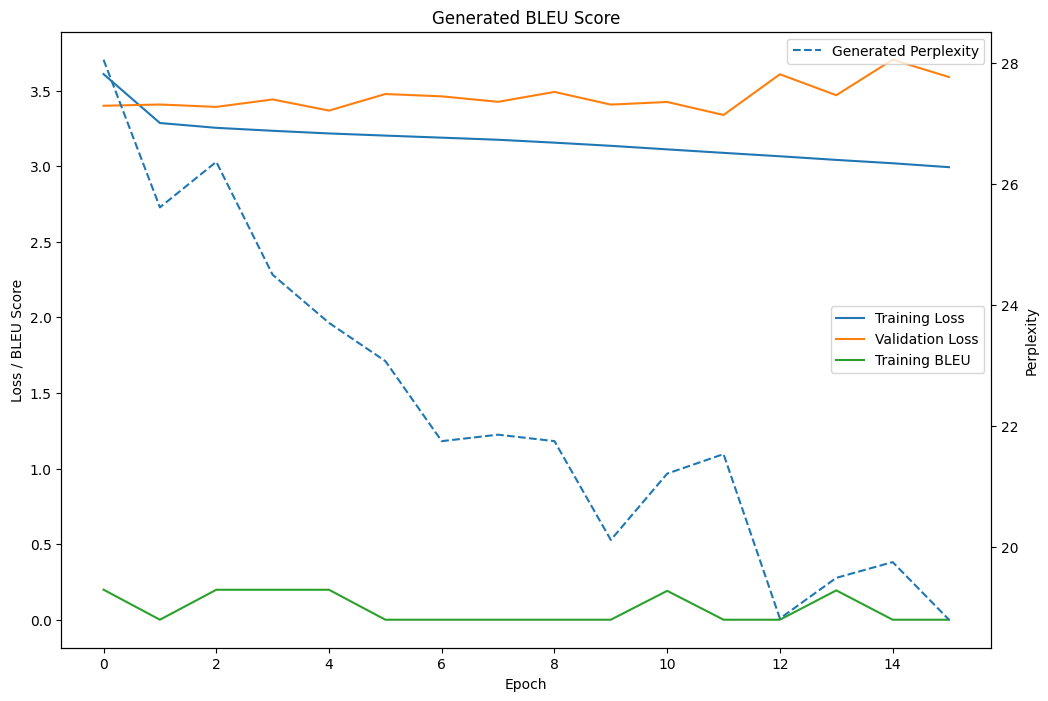

In [146]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(12, 8))

# Plot loss
ax.plot(loss_dict['train_losses'], label='Training Loss')
ax.plot(loss_dict['val_losses'], label='Validation Loss')

# Plot BLEU scores
ax.plot(loss_dict['gen_bleu'], label='Training BLEU')

ax.set_title('Generated BLEU Score')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss / BLEU Score')
ax.legend()

# plot perplexity
ax2 = ax.twinx()
ax2.plot(loss_dict['perplexity'], label='Generated Perplexity', linestyle='dashed')
ax2.set_ylabel('Perplexity')
ax2.legend()

plt.show()


## Model Evaluation

We define a function to compute BLEU scores for generated stanzas compared to reference stanzas. We then generate and evaluate poems based on a few input prompts.

In [147]:
poems = [
    'میازار موری که داته کش است',
    'که اخذ کرد او دیپ با فاطمی',
    'چون سنگها صدای مرا گوش می کنی',
    'از دام بوسه راه گریزی اگر که بود',
    'گل من را اذیت نکنین',
    'توانا بود هرکه دانا بود',
]

for poem in poems:
    gen_encoding = {'input_ids': 0, 'attention_mask': 0}
    input_ = tokenizer(
        [tokenizer.eos_token + poem + tokenizer.bos_token],
        truncation=True,
        padding="max_length",
        return_tensors='pt'
    )
    gen_encoding['input_ids'] = input_["input_ids"].to(device)
    gen_encoding['attention_mask'] = torch.ones_like(gen_encoding['input_ids']).to(device)
    gen = model.module if parallel else model
    outputs = gen.generate(
        **gen_encoding,
        top_k=50,
        max_length=30,
        num_beams=5,
        no_repeat_ngram_size=2,
        num_return_sequences=1,
        do_sample = False,
        pad_token_id=tokenizer.eos_token_id, # Open end generation
    )
    in_stanza = tokenizer.decode(gen_encoding['input_ids'][0], skip_special_tokens=True)
    out_stanza = tokenizer.decode(outputs[0], skip_special_tokens=True)
    out_stanza = out_stanza.replace(in_stanza, in_stanza + '  ,  ')
    print('Generated sequence: ')
    print(out_stanza)
    
#     target_array = input_["input_ids"].cpu().numpy().flatten()
#     output_array = outputs.cpu().numpy().flatten()
#     bleu_score = compute_bleu(output_array, target_array)
#     print(f'BLEU Score: {bleu_score:.4f}\n')

Generated sequence: 
میازار موری که داته کش است  ,  زیان زمانان سنانزیان به و رقم
Generated sequence: 
که اخذ کرد او دیپ با فاطمی  ,   برادرش زانیمب ببر قیر ز اسب
Generated sequence: 
چون سنگها صدای مرا گوش می کنی  ,   بال رسدان مرا بسی نشنیده و ترندند
Generated sequence: 
از دام بوسه راه گریزی اگر که بود  ,  وست و باش گنج بود بود رایند مرا راست
Generated sequence: 
گل من را اذیت نکنین  ,  ب مرا مرا پدر وها رازبان کهیم و
Generated sequence: 
توانا بود هرکه دانا بود  ,  ب بودفت بود بود و بودوی رسد
